# Comparing fitted runs
Comparison of SLFs and microphysical parameters between model base states and fitted runs.

In [1]:
import sys
# Add common resources folder to path
sys.path.append("/mnt/mcc-ns9600k/jonahks/git_repos/netcdf_analysis/Common/")
sys.path.append("Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    polyfit, ccrs, LinearRegression, metrics
    )

from functions import (
    masked_average, interpretNS, plot_slf_isotherms, 
    add_weights, process_caliop, process_for_slf,
    noresm_slf_to_df, regress_1d
    )

from classes import CT_SLF_Metric

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
host = os.uname()[1]
if 'jupyter' in host.split('-'): # Check if running on NIRD through the Jupyter Hub
    print('Running through MC2 Jupyter Hub')
    model_dir = '/mnt/mcc-ns9600k/jonahks/'
    os.chdir(model_dir)

else:  # Assume that we're running on a local machine and mounting NIRD
    print('Running on %s, attempting to mount ns9600k/jonahks/ from NIRD' % str(host))
    os.system('fusermount -zu ~/drivemount/')  # unmount first
    os.system('sshfs jonahks@login.nird.sigma2.no:"p/jonahks/" ~/drivemount/')    # Calling mountnird from .bashrc doesn't work
    os.chdir('/home/jonahks/drivemount/')
    save_dir = '~/DATAOUT/'
    save_to = os.path.expanduser(save_dir)

output_dir = 'figures/'
case_dir = 'mnth15runs/'   # inconsistent label compared to jupy_test
mods_dir = 'inp_validation/'

# Check that each important directory can be accessed:    
access_paths = os.path.exists(mods_dir) and os.path.exists(output_dir) and os.path.exists(mods_dir)
print('Can access all directory paths:', access_paths)

Running through MC2 Jupyter Hub
Can access all directory paths: True


In [3]:
files = os.listdir(case_dir)
files.sort()
files

['.ipynb_checkpoints',
 '20191122_161009_sampleparamset_wbf_1_inp_1',
 '20191127_162007_sampleparamset_wbf_0.01_inp_1',
 '20191128_171713_sampleparamset_wbf_10_inp_1',
 '20191128_171713_sampleparamset_wbf_1_inp_10',
 '20191209_180424_sampleparamset_wbf_1_inp_0.1',
 '20191210_152149_sampleparamset_wbf_1_inp_0.1',
 '20191210_152149_sampleparamset_wbf_1_inp_10',
 '20191217_134307_singleparam_jolt_wbf_1_inp_0',
 '20191217_145440_singleparam_jolt_wbf_1_inp_1000',
 '20191219_151155_singleparam_cttest_wbf_1_inp_1.cam.h0.0001-01',
 '20191230_130025_singleparam_cttest15_wbf_1_inp_1',
 '20200109_1541_wbf_1.0_inp_1.0',
 '20200110_142006_singleparam_nudge_wbf_1_inp_1000',
 '20200112_002538_singleparam_nudge_wbf_1_inp_0',
 '20200116_130416_nudged_wbfmods_wbf_0.01_inp_1',
 '20200116_130416_nudged_wbfmods_wbf_10_inp_1',
 '20200128_142303_singleparam_frzrtvarsm15_wbf_1_inp_100',
 '20200204_113441_singleparam_inpcheck_wbf_1_inp_10',
 '20200204_120214_singleparam_wbfcheck_wbf_0.1_inp_1',
 '20200218_1726

In [6]:
cam6_origin_case = '20200109_1541_wbf_1.0_inp_1.0'
cam61_origin_case = '20200319_132512_singleparam_cam61arctic2m15_wbf_1_inp_1'

mainmetric = CT_SLF_Metric(case_dir)
mainmetric.add_case(cam6_origin_case) # origin point
mainmetric.add_case(cam61_origin_case) # origin point
mainmetric.add_case('20200327_170021_singleparam_noresm2tests_wbf_1_inp_10')
mainmetric.add_case('20200408_184035_singleparam_cam61_arctic2_wbf_0.2_inp_0.3')
mainmetric.add_case('20200405_135130_singleparam_cam61_arctic2_wbf_1.0_inp_0.05')

Trying to load concatenated file for 20200109_1541_wbf_1.0_inp_1.0


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Trying to load concatenated file for 20200319_132512_singleparam_cam61arctic2m15_wbf_1_inp_1


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Trying to load concatenated file for 20200327_170021_singleparam_noresm2tests_wbf_1_inp_10


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Trying to load concatenated file for 20200408_184035_singleparam_cam61_arctic2_wbf_0.2_inp_0.3


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Trying to load concatenated file for 20200405_135130_singleparam_cam61_arctic2_wbf_1.0_inp_0.05


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [16]:
case1 = mainmetric.get_case('20200405_135130_singleparam_cam61_arctic2_wbf_1.0_inp_0.05')

In [17]:
_da = case1.case_da
_da['time']

<xarray.DataArray 'time' (time: 12)>
array(['2009-10-01T00:00:00.000000000', '2009-11-01T00:00:00.000000000',
       '2009-12-01T00:00:00.000000000', '2010-01-01T00:00:00.000000000',
       '2010-02-01T00:00:00.000000000', '2010-03-01T00:00:00.000000000',
       '2010-04-01T00:00:00.000000000', '2010-05-01T00:00:00.000000000',
       '2010-06-01T00:00:00.000000000', '2010-07-01T00:00:00.000000000',
       '2010-08-01T00:00:00.000000000', '2010-09-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2009-10-01 2009-11-01 ... 2010-09-01
Attributes:
    standard_name:  time
    long_name:      time
    bounds:         time_bnds
    axis:           T

/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


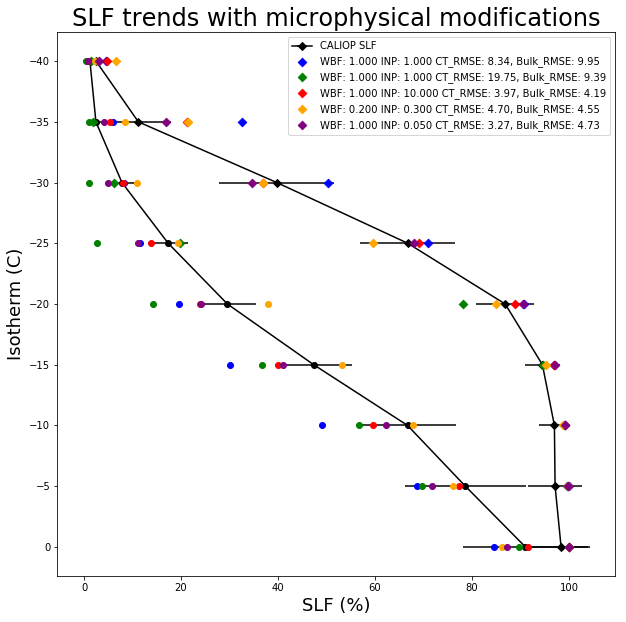

In [5]:
initialplot = mainmetric.plot_isos_all()

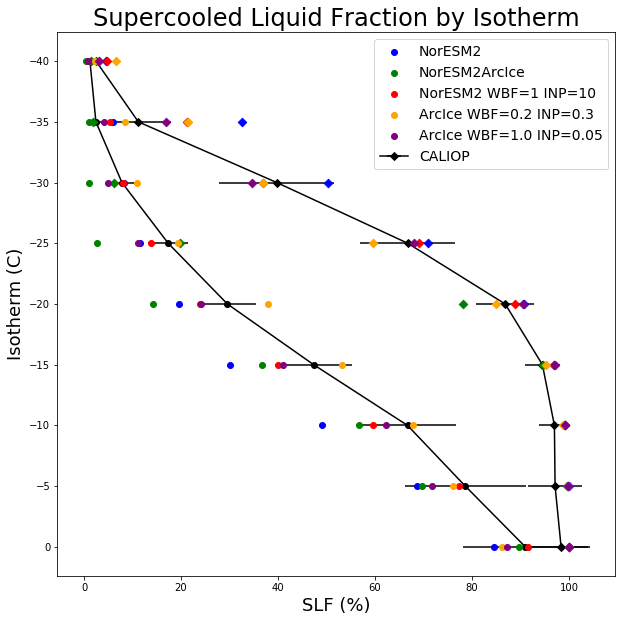

In [6]:
_ax = initialplot.get_axes()[0]
_ax.set_title('Supercooled Liquid Fraction by Isotherm', fontsize=24)
_handles, _labels = _ax.get_legend_handles_labels()
new_hands = _handles[1::2] # pick every other handle object (since they're paired)
new_labs = ['NorESM2', 'NorESM2ArcIce','NorESM2 WBF=1 INP=10 ','ArcIce WBF=0.2 INP=0.3','ArcIce WBF=1.0 INP=0.05','CALIOP']
_ax.legend(new_hands, new_labs, fontsize=14)
initialplot

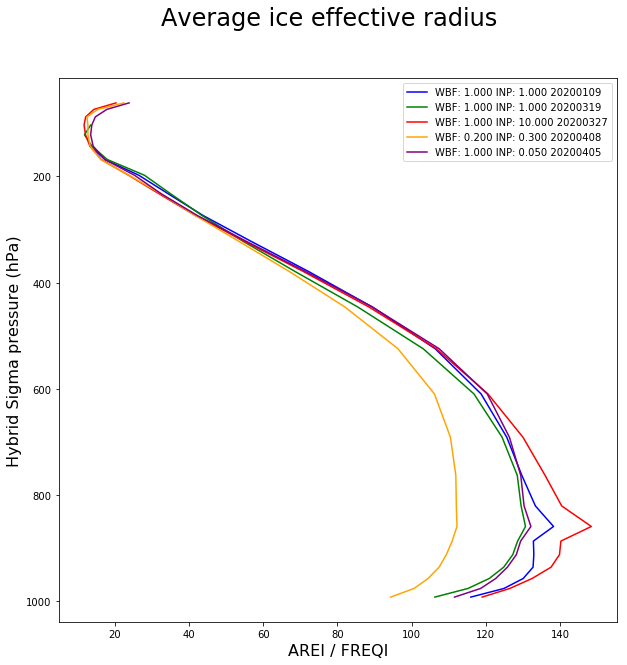

In [7]:
icesize = mainmetric.plot_var_ratio('AREI','FREQI')

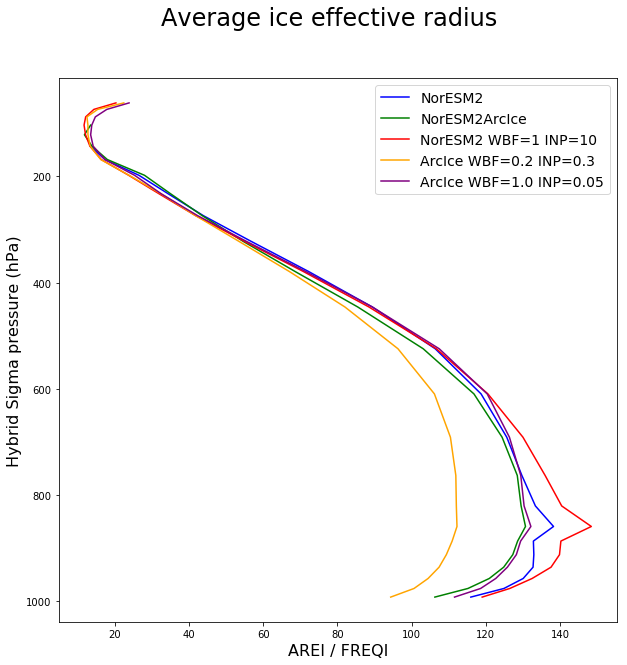

In [8]:
_ax = icesize.get_axes()[0]
_handles, _labels = _ax.get_legend_handles_labels()
new_hands = _handles # pick every other handle object (since they're paired)
new_labs = ['NorESM2', 'NorESM2ArcIce','NorESM2 WBF=1 INP=10 ','ArcIce WBF=0.2 INP=0.3','ArcIce WBF=1.0 INP=0.05','CALIOP']
_ax.legend(new_hands, new_labs, fontsize=14)
icesize

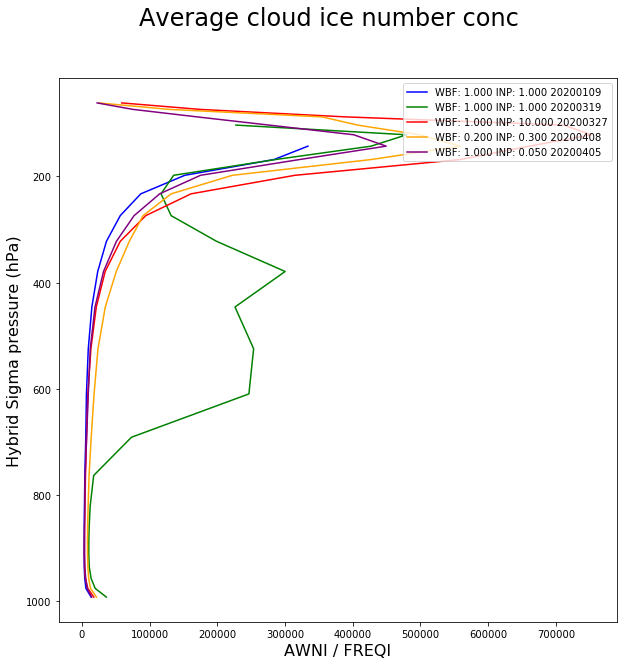

In [9]:
incloudicenumber = mainmetric.plot_var_ratio('AWNI','FREQI')

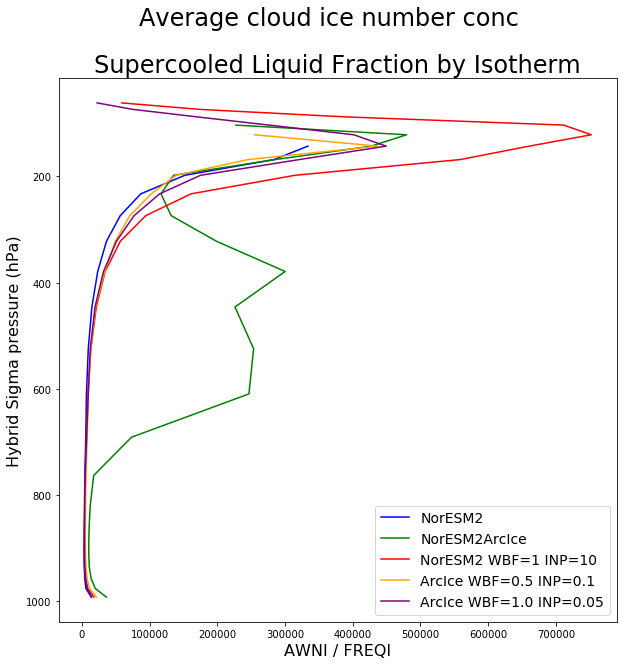

In [13]:
_ax = incloudicenumber.get_axes()[0]
_ax.set_title('Supercooled Liquid Fraction by Isotherm', fontsize=24)
_handles, _labels = _ax.get_legend_handles_labels()
new_hands = _handles # pick every other handle object (since they're paired)
new_labs = ['NorESM2', 'NorESM2ArcIce','NorESM2 WBF=1 INP=10 ','ArcIce WBF=0.2 INP=0.3','ArcIce WBF=1.0 INP=0.05','CALIOP']
_ax.legend(new_hands, new_labs, fontsize=14)
incloudicenumber

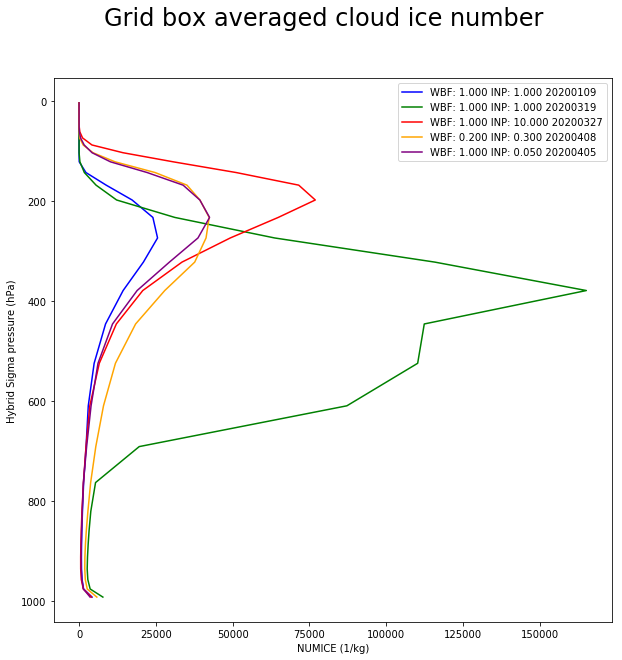

In [10]:
icenumber = mainmetric.plot_single_var('NUMICE')

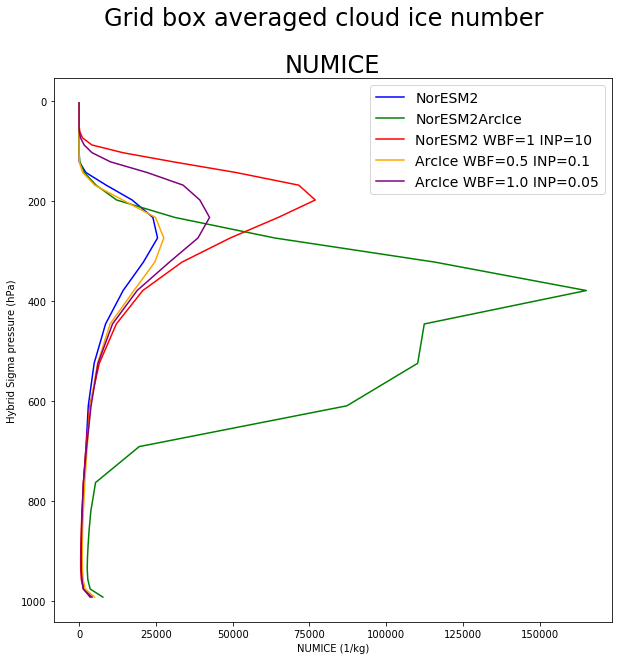

In [18]:
_ax = icenumber.get_axes()[0]
_ax.set_title('NUMICE', fontsize=24)
_handles, _labels = _ax.get_legend_handles_labels()
new_hands = _handles # pick every other handle object (since they're paired)
new_labs = ['NorESM2', 'NorESM2ArcIce','NorESM2 WBF=1 INP=10 ','ArcIce WBF=0.2 INP=0.3','ArcIce WBF=1.0 INP=0.05','CALIOP']
_ax.legend(new_hands, new_labs, fontsize=14)
icenumber

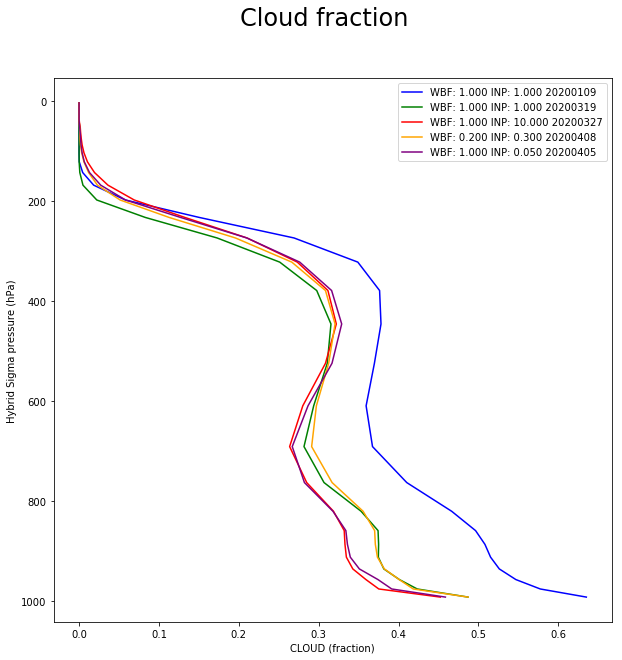

In [11]:
cloud = mainmetric.plot_single_var('CLOUD')

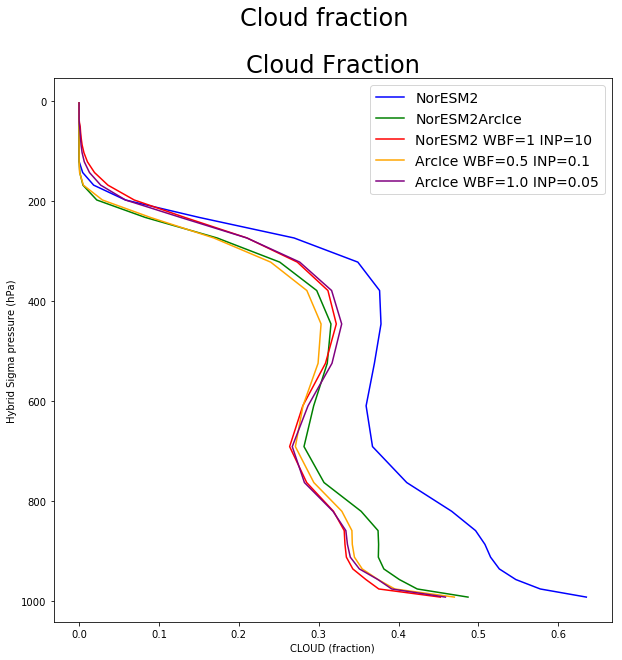

In [19]:
_ax = cloud.get_axes()[0]
_ax.set_title('Cloud Fraction', fontsize=24)
_handles, _labels = _ax.get_legend_handles_labels()
new_hands = _handles # pick every other handle object (since they're paired)
new_labs = ['NorESM2', 'NorESM2ArcIce','NorESM2 WBF=1 INP=10 ','ArcIce WBF=0.2 INP=0.3','ArcIce WBF=1.0 INP=0.05','CALIOP']
_ax.legend(new_hands, new_labs, fontsize=14)
cloud